In [84]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats

In [85]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.31-23


In [86]:
measurements_used = 30
energy_per_time = 1000
generate_graphs = False

In [87]:
experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
experiment_number = 1

used_dut_name = [
    'workstationone'
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe'
]

used_test_case_names.sort()

used_compilers = [
    'clang', 'intel-one-api', 'min-gw', 'msvc'
]

used_compilers.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"

windows_mi = [
    ipg, lhm, clamp, plug
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg #lhm, ipg, rapl
]

used_mi_names.sort()

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

### DUTs

In [88]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [89]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
2,3,workstationone,unix,dev
3,4,workstationone,win32nt,dev


In [90]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod


### Test Cases

In [91]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [92]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}')")

In [93]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [94]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,ipg,100
1,2,lhm,100
2,3,clamp,100
3,4,rapl,100
4,5,clamp,500
5,6,scaphandre,100


In [95]:
used_mi_query_list = []

if ipg in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate})")

if lhm in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

if rapl in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{rapl}' and {SAMPLE_RATE} == {rapl_sample_rate})")

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [96]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [97]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"


In [98]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

### Experiment Names

In [99]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test


## Used Things

In [100]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod


In [101]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded
10,11,mandelbrot.exe,msvc,c++,-openmp,microbenchmarks,16000,multi-threaded


In [102]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100


In [103]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
11,12,idle-case.exe,msvc,c++,-openmp,microbenchmarks,,multi-threaded


In [104]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [105]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

for dut_index, dut_row in used_dut.iterrows():
    dut_id = dut_row[ID]
    dut_name = dut_row[NAME]
    dut_os = dut_row[OS]
    for mi_index, mi_row in used_mi.iterrows():
        mi_id = mi_row[ID]
        mi_name = mi_row[NAME]
        
        if dut_os == windows and not mi_name in windows_mi:
            continue
        
        if dut_os == linux and not mi_name in linux_mi:
            continue
        
        for config_index, config_row in used_configs.iterrows():
            config_id = config_row[ID]
            config_cores = config_row[ALLOCATED_CORES]
            if config_cores == "[]":
                config_cores = 'all'
            for tc_index, tc_row in used_tc.iterrows():
                tc_id = tc_row[ID]
                tc_name = tc_row[NAME]
                tc_compiler = tc_row[COMPILER]
                tc_language = tc_row[LANGUAGE]
                tc_optimizations = tc_row[OPTIMIZATIONS]
                tc_test_case_size = tc_row[TEST_CASE_SIZE]
                tc_threads = tc_row[THREADS]
                
                if dut_os == linux and tc_compiler == "msvc":
                    continue
                
                tc_idle_case = query.get_idle_case(used_idle_case, tc_compiler, tc_language, tc_optimizations, tc_test_case_size, tc_threads)
                tc_idle_case_id =int(tc_idle_case[ID].iloc[0])
                
                print(f"dut {dut_name}, mi {mi_name}, config {config_id}, tc {tc_name}")
                tc_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_id, experiment_name, experiment_number)
                tc_idle_case_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_idle_case_id, experiment_name, experiment_number)
                
                tc_collection_id = int(tc_collection[ID].iloc[0])
                tc_idle_case_collection_id = int(tc_idle_case_collection[ID].iloc[0])
                
                tc_measurements = rep.get_measurements(db, tc_collection_id)
                tc_idle_case_measurements = rep.get_measurements(db, tc_idle_case_collection_id)
                
                key = f"{tc_name}.{mi_name}.{dut_name}.{config_cores}.{tc_compiler}.{dut_os}"
                
                dram_energy_results[key] = list(tc_measurements["DramEnergyInJoules"])
                cpu_energy_results[key] = list(tc_measurements["CpuEnergyInJoules"])
                gpu_energy_results[key] = list(tc_measurements["GpuEnergyInJoules"])
                duration_results[key] = list(tc_measurements["Duration"])
                
                idle_cpu_consumption = df_util.get_cpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_gpu_consumption = df_util.get_gpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_dram_consumption = df_util.get_dram_energy_per_time(tc_idle_case_measurements, energy_per_time)
                
                cpu_dynamic_energy_consumption[key] = df_util.get_cpu_dynamic_energy(tc_measurements, idle_cpu_consumption, energy_per_time)
                gpu_dynamic_energy_consumption[key] = df_util.get_gpu_dynamic_energy(tc_measurements, idle_gpu_consumption, energy_per_time)
                dram_dynamic_energy_consumption[key] = df_util.get_dram_dynamic_energy(tc_measurements, idle_dram_consumption, energy_per_time)

dut workstationone, mi ipg, config 1, tc fannkuch-redux.exe
dut workstationone, mi ipg, config 1, tc mandelbrot.exe
dut workstationone, mi ipg, config 1, tc fannkuch-redux.exe
dut workstationone, mi ipg, config 1, tc mandelbrot.exe
dut workstationone, mi ipg, config 1, tc fannkuch-redux.exe
dut workstationone, mi ipg, config 1, tc mandelbrot.exe
dut workstationone, mi ipg, config 1, tc fannkuch-redux.exe
dut workstationone, mi ipg, config 1, tc mandelbrot.exe


In [106]:
config_cores == "[]"

False

In [107]:
for key, value in dram_energy_results.items():
    dram_energy_results[key] = value[:measurements_used]
    
for key, value in cpu_energy_results.items():
    cpu_energy_results[key] = value[:measurements_used]

for key, value in gpu_energy_results.items():
    gpu_energy_results[key] = value[:measurements_used]

for key, value in duration_results.items():
    duration_results[key] = value[:measurements_used]
    
for key, value in cpu_dynamic_energy_consumption.items():
    cpu_dynamic_energy_consumption[key] = value[:measurements_used]

for key, value in gpu_dynamic_energy_consumption.items():
    gpu_dynamic_energy_consumption[key] = value[:measurements_used]
    
for key, value in dram_dynamic_energy_consumption.items():
    dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [108]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

In [109]:
dram_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt,mandelbrot.exe.ipg.workstationone.all.clang.win32nt,mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.ipg.workstationone.all.min-gw.win32nt,mandelbrot.exe.ipg.workstationone.all.msvc.win32nt
0,17.944031,10.169495,18.789490,26.166260,18.414551,0.665100,27.386353,26.793457
1,17.308655,11.929871,20.141174,28.621399,18.329529,0.639954,27.399475,26.632324
2,16.729980,11.209534,19.089355,25.871704,18.318970,0.621399,27.546082,26.912598
3,17.570190,10.774048,24.487671,27.396301,18.424683,0.634216,27.405884,26.850220
4,18.302307,11.413147,18.918091,26.288269,18.316284,0.633850,27.341675,26.689209
5,17.423096,10.865540,19.067627,30.663757,18.315430,0.634583,27.392822,26.693909
6,15.757019,11.968628,19.064148,24.166138,18.295166,0.647522,27.386658,26.685425
7,18.220947,12.087646,20.364014,25.466248,18.396057,0.629517,27.525146,26.640564
8,17.615540,11.655457,19.440002,25.133972,18.279053,0.626160,27.421204,26.717957
9,17.788757,10.801636,18.928284,26.992188,18.288269,0.660034,27.409912,26.792603


Combined DRAM Energy Consumption in Joules


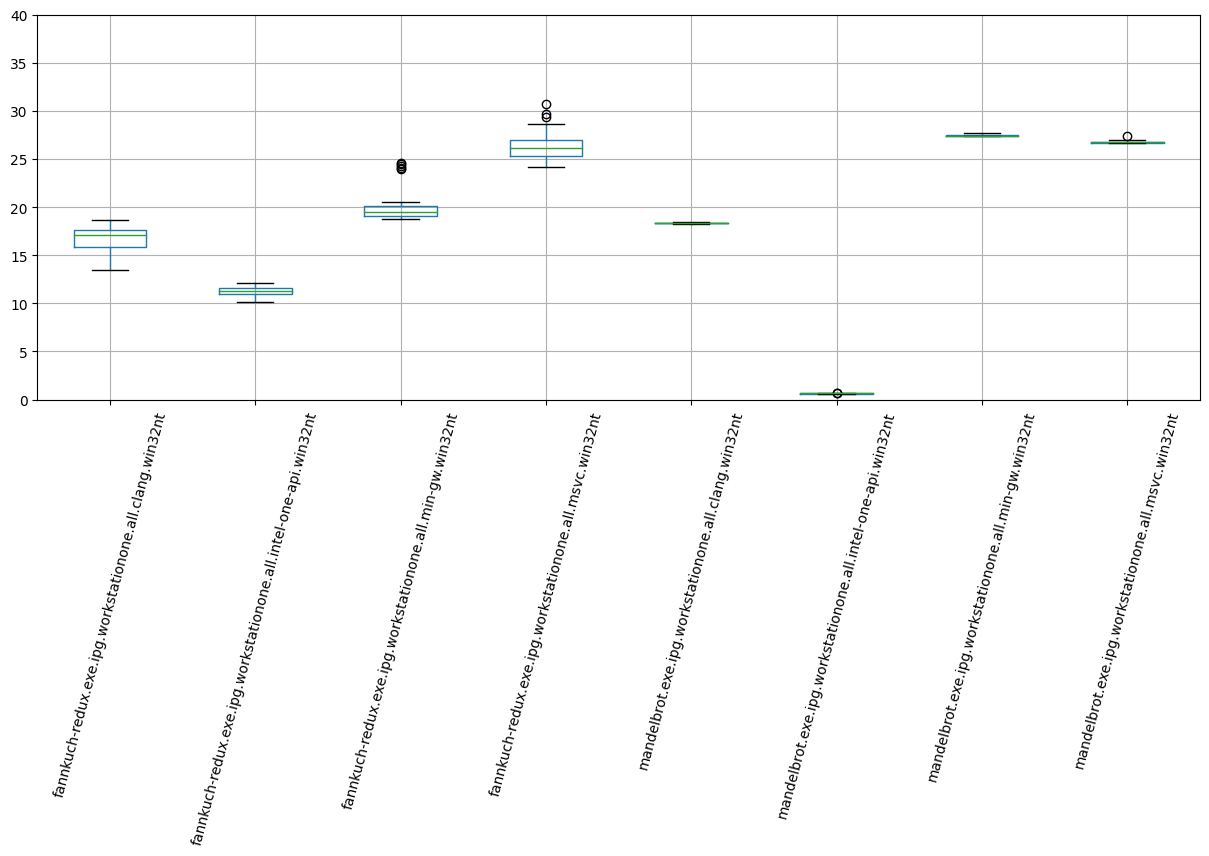

Combined CPU Energy Consumption in Joules


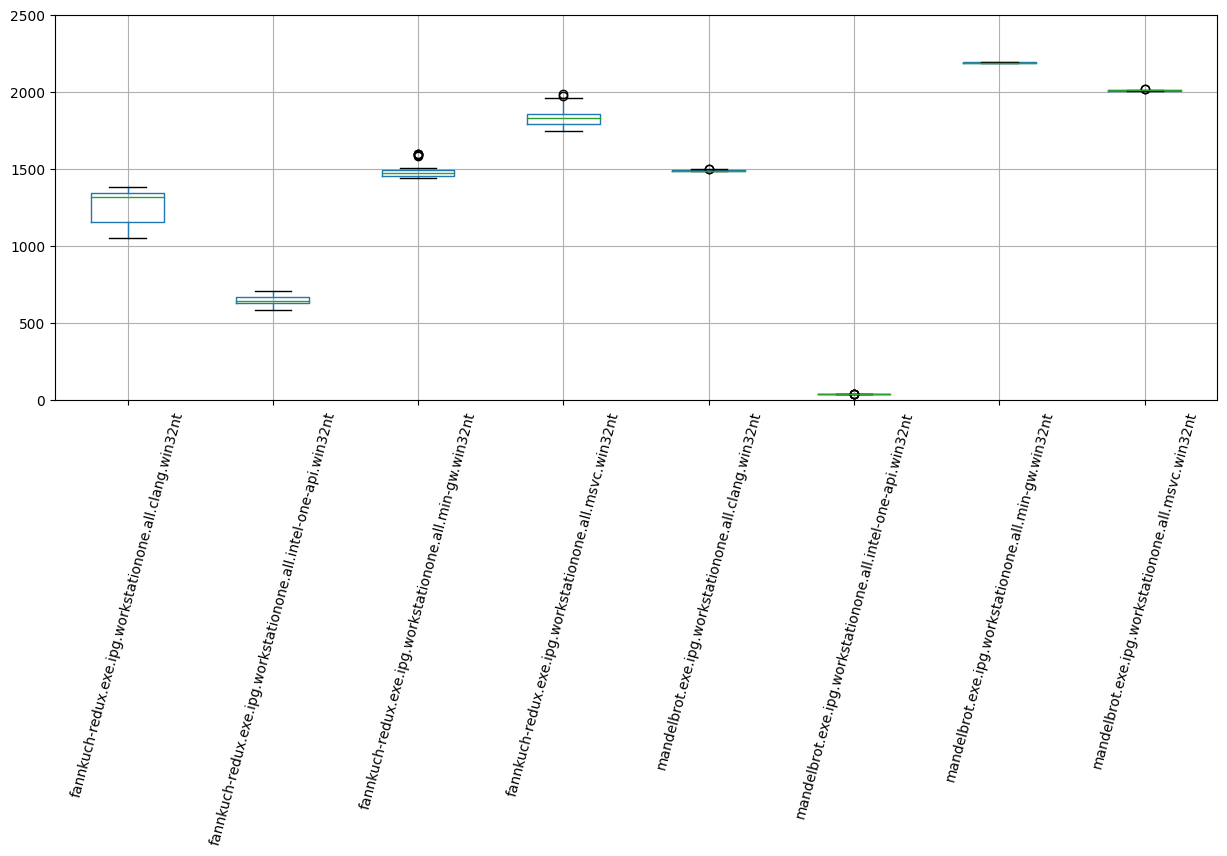

Combined GPU Energy Consumption in Joules


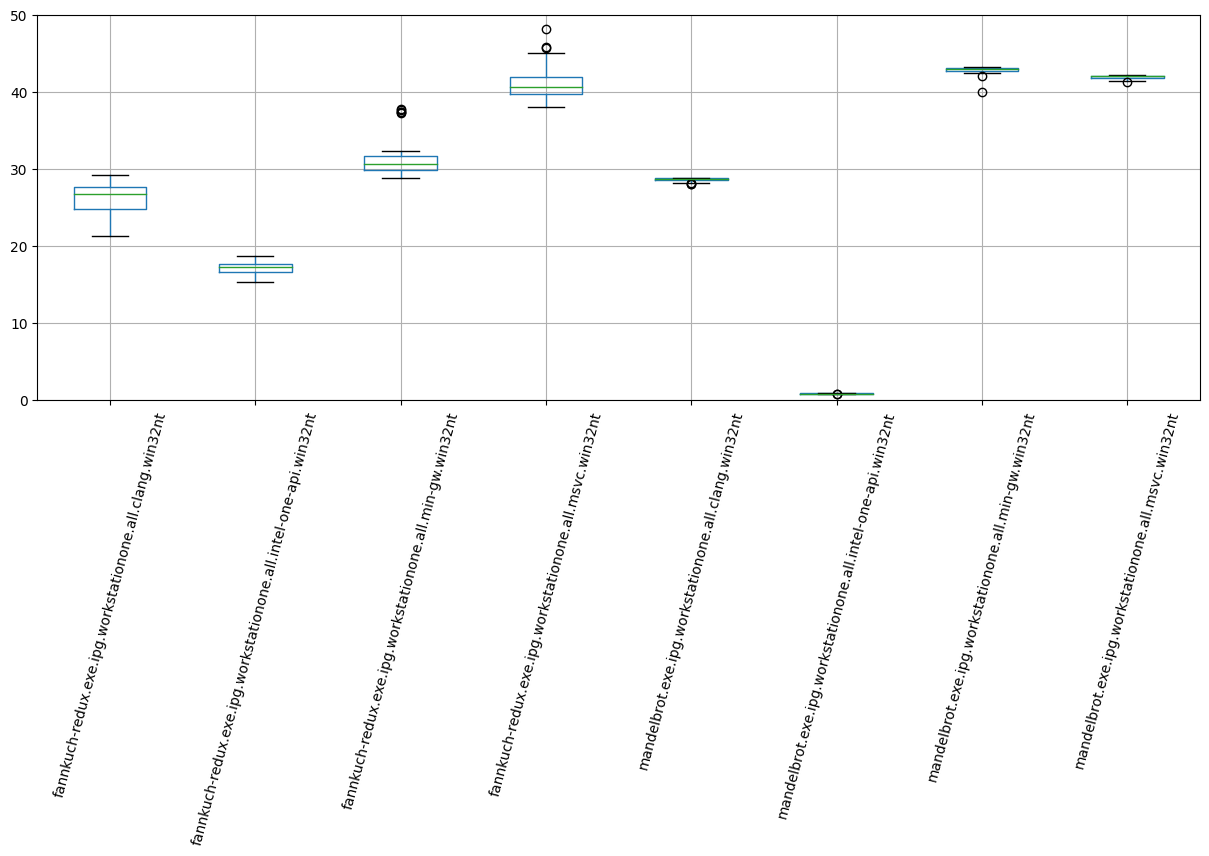

Duration of Test Case


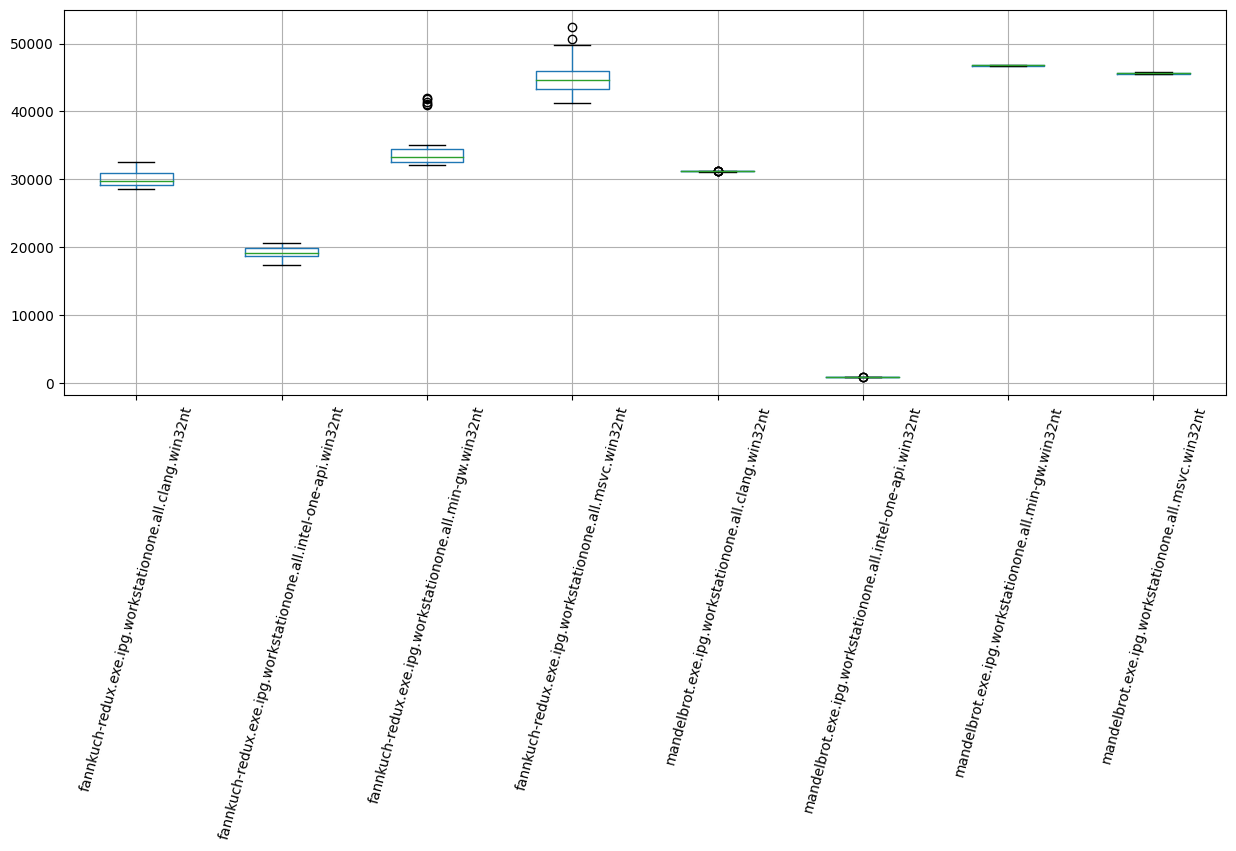

In [110]:
print("Combined DRAM Energy Consumption in Joules")
dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75)
dram_boxplot.plot()
plot.ylim(0, 40)
plot.show()

print("Combined CPU Energy Consumption in Joules")
cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=75)
cpu_boxplot.plot()
cpu_boxplot
plot.ylim(0,2500)
plot.show()

print("Combined GPU Energy Consumption in Joules")
gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=75)
gpu_boxplot.plot()
plot.ylim(0,50)
plot.show()

print("Duration of Test Case")
duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=75)
duration_boxplot.plot()
# plot.ylim(0,40)
plot.show()

Dynamic DRAM Energy Consumption in Watts


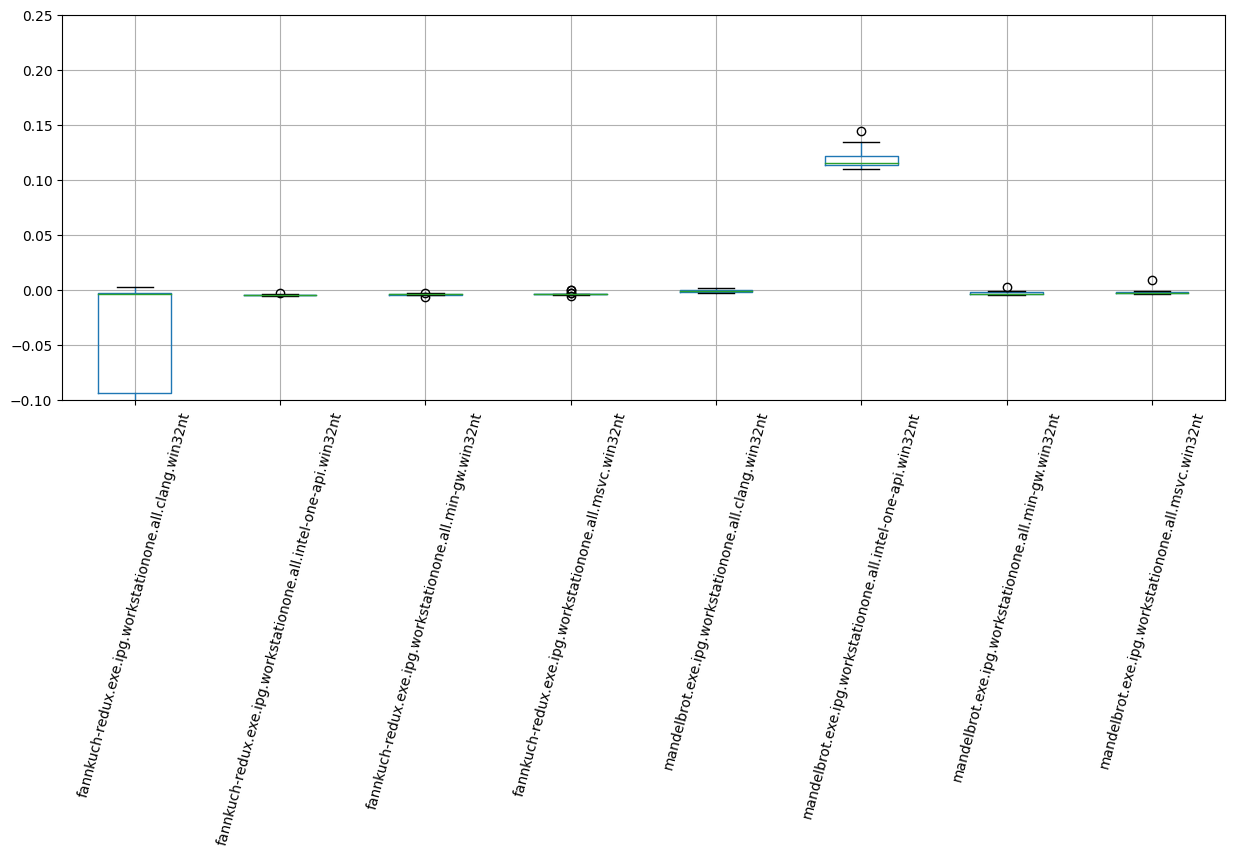

Dynamic CPU Energy Consumption in Watts


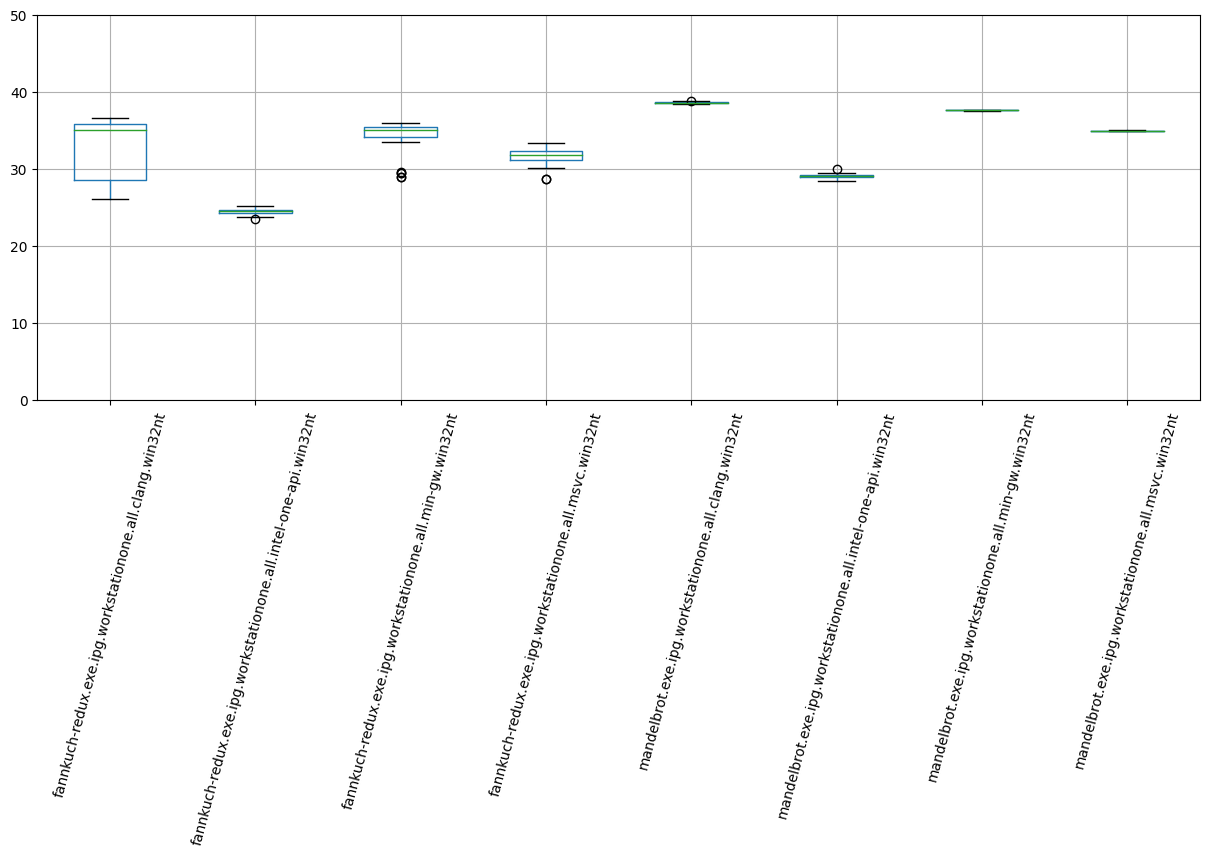

Dynamic GPU Energy Consumption in Watts


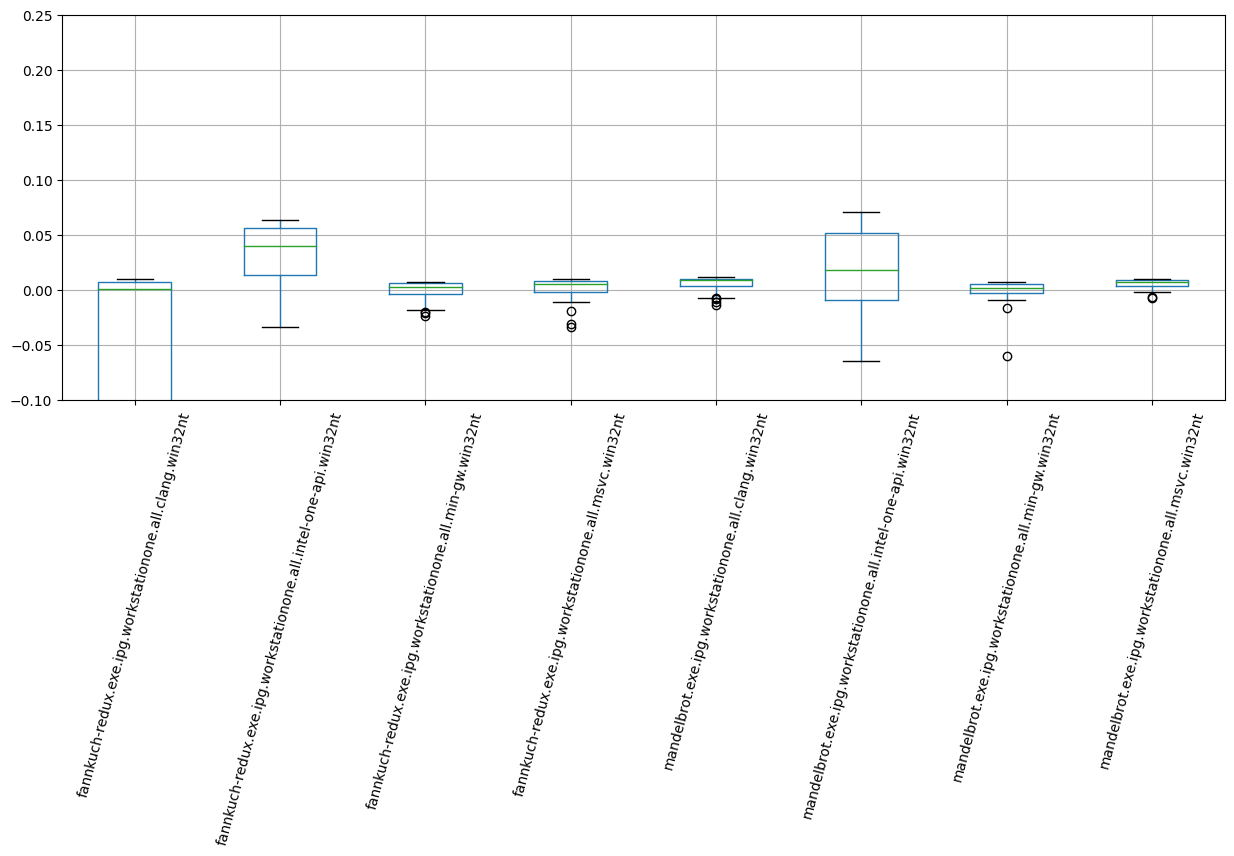

In [111]:
print("Dynamic DRAM Energy Consumption in Watts")
dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
dynamic_dram_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()

print("Dynamic CPU Energy Consumption in Watts")
dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
dynamic_cpu_boxplot.plot()
plot.ylim(0,50)
plot.show()

print("Dynamic GPU Energy Consumption in Watts")
dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
dynamic_gpu_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()


In [112]:
cpu_dynamic_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt,mandelbrot.exe.ipg.workstationone.all.clang.win32nt,mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.ipg.workstationone.all.min-gw.win32nt,mandelbrot.exe.ipg.workstationone.all.msvc.win32nt
0,34.567827,24.583273,35.621682,31.738751,38.459162,29.901836,37.515621,34.853441
1,35.625896,24.571549,34.376753,31.123275,38.522748,28.781978,37.585171,34.960225
2,36.522181,24.518630,35.376826,32.427514,38.459702,29.193250,37.572424,34.847810
3,36.157709,24.190246,28.889563,30.782656,38.421668,29.313461,37.612732,34.918249
4,34.433066,24.766111,35.718227,31.643739,38.434603,29.217180,37.610174,34.923891
5,35.740789,24.512327,35.386477,28.660657,38.517861,29.132893,37.605794,34.929534
6,26.581922,24.315405,35.423951,33.052705,38.431896,28.425154,37.558012,34.938560
7,34.874639,23.696712,33.656464,32.146045,38.419565,29.482803,37.535683,34.947818
8,35.036620,24.655870,34.899880,32.235725,38.494630,28.869978,37.580403,34.917002
9,35.201449,24.292608,35.464190,31.200066,38.533101,28.491809,37.579276,34.870133


In [113]:
def list_to_label(lst):
    if len(lst) == 1:
        return lst[0]
    elif len(lst) == 2:
        return f"{lst[0]} and {lst[1]}"
    else:
        return ", ".join(lst[:-1]) + f" and {lst[-1]}"

In [114]:
box_plot_raw_data = [
    {
        "data" : cpu_dynamic_df,
        "name" : "cpu",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "average Energy Consumption (Watt)"
    },
    {
        "data" : cpu_df,
        "name" : "cpu",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "average Energy Consumption (Watt)"
    },
    {
        "data" : dram_dynamic_df,
        "name" : "dram",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : -0.1,
        "xmax" : 0.1,
        "xlabel" : "average Energy Consumption (Watt)"
    },
    {
        "data" : dram_df,
        "name" : "dram",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 40,
        "xlabel" : "average Energy Consumption (Watt)"
    },
    {
        "data" : gpu_dynamic_df,
        "name" : "gpu",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : -0.1,
        "xmax" : 0.1,
        "xlabel" : "average Energy Consumption (Watt)"
    },
    {
        "data" : gpu_df,
        "name" : "gpu",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "average Energy Consumption (Watt)"
    },
    {
        "data" : duration_df,
        "name" : "runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50000,
        "xlabel" : "average runtime (ms)"
    }
]

In [115]:
if generate_graphs:
    for plot_data in box_plot_raw_data:
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        
        title = f"The {data_type} of the {name}"
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(data, used_test_case_names, used_mi_names, used_dut_name, used_allocated_cores, used_compiler_str, used_os_names)
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}"
        
        c_test_cases = list_to_label(used_test_case_names)
        c_compiler = list_to_label(used_compilers)
        c_duts = list_to_label(used_dut_name)
        c_measuring_instrument = list_to_label(used_mi_names)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = f"{data_type} measurements on the {name}, measured by {c_measuring_instrument} on {c_duts}, for test cases {c_test_cases} compiled on {c_compiler}"
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_number}/{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        path_util.write_to_path(box_plot_path, box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating plots is disabled


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [116]:
cpu_dynamic_df

,fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt,fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt,fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt,fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt,mandelbrot.exe.ipg.workstationone.all.clang.win32nt,mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt,mandelbrot.exe.ipg.workstationone.all.min-gw.win32nt,mandelbrot.exe.ipg.workstationone.all.msvc.win32nt
0,34.567827,24.583273,35.621682,31.738751,38.459162,29.901836,37.515621,34.853441
1,35.625896,24.571549,34.376753,31.123275,38.522748,28.781978,37.585171,34.960225
2,36.522181,24.518630,35.376826,32.427514,38.459702,29.193250,37.572424,34.847810
3,36.157709,24.190246,28.889563,30.782656,38.421668,29.313461,37.612732,34.918249
4,34.433066,24.766111,35.718227,31.643739,38.434603,29.217180,37.610174,34.923891
5,35.740789,24.512327,35.386477,28.660657,38.517861,29.132893,37.605794,34.929534
6,26.581922,24.315405,35.423951,33.052705,38.431896,28.425154,37.558012,34.938560
7,34.874639,23.696712,33.656464,32.146045,38.419565,29.482803,37.535683,34.947818
8,35.036620,24.655870,34.899880,32.235725,38.494630,28.869978,37.580403,34.917002
9,35.201449,24.292608,35.464190,31.200066,38.533101,28.491809,37.579276,34.870133


In [117]:
Z = 1.96
E = 0.03

# Z = 2.58
# E = 0.01

include_outliers = False

used_df = cpu_dynamic_df

for column in used_df.columns:
    used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
    
    values = used_df_without_outlisers
    n_zero_without = math_util.get_cochran(values, Z, E)
    
    values = list(used_df[column])
    n_zero = math_util.get_cochran(values, Z, E)
    
    print(f"{column} - with outliers: {n_zero}, without outliers: {n_zero_without}")

fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt - with outliers: 61086.78895695505, without outliers: 61086.78895695505
fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt - with outliers: 650.6650973375022, without outliers: 550.5855899266072
fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt - with outliers: 21052.296943036825, without outliers: 1644.5678093721585
fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt - with outliers: 5442.691294269679, without outliers: 2994.024899136164
mandelbrot.exe.ipg.workstationone.all.clang.win32nt - with outliers: 49.75391023947722, without outliers: 40.46157916924422
mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt - with outliers: 325.9087006976488, without outliers: 222.12401325475344
mandelbrot.exe.ipg.workstationone.all.min-gw.win32nt - with outliers: 3.8062234983789964, without outliers: 3.8062234983789964
mandelbrot.exe.ipg.workstationone.all.msvc.win32nt - with outliers: 9.501946269545774, without

fannkuch-redux.exe.ipg.workstationone.all.clang.win32nt


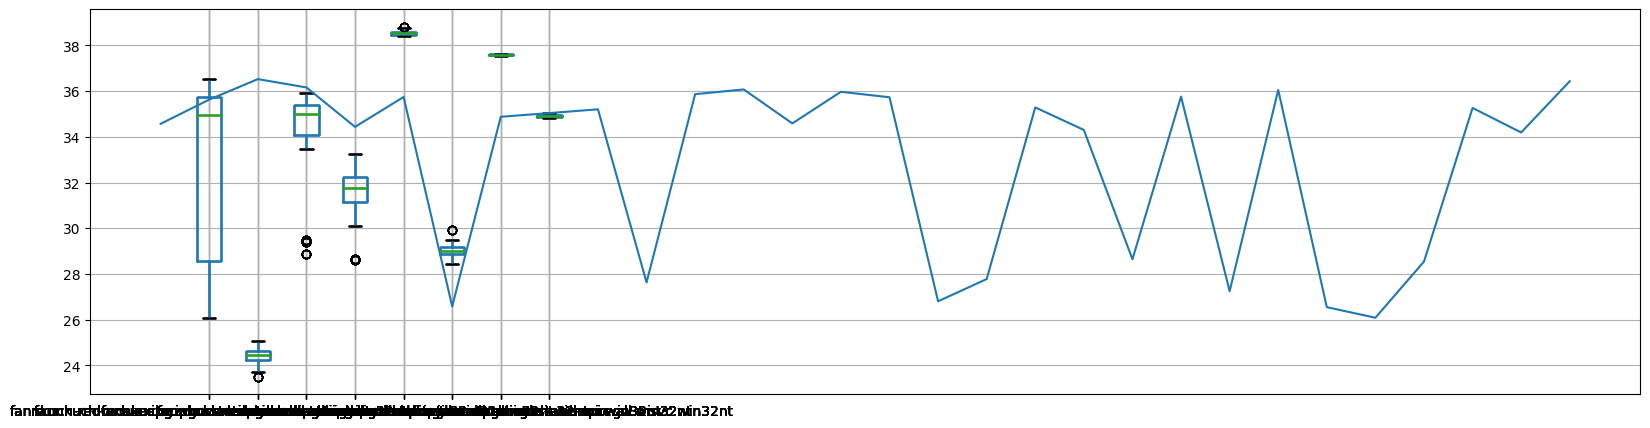

fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt


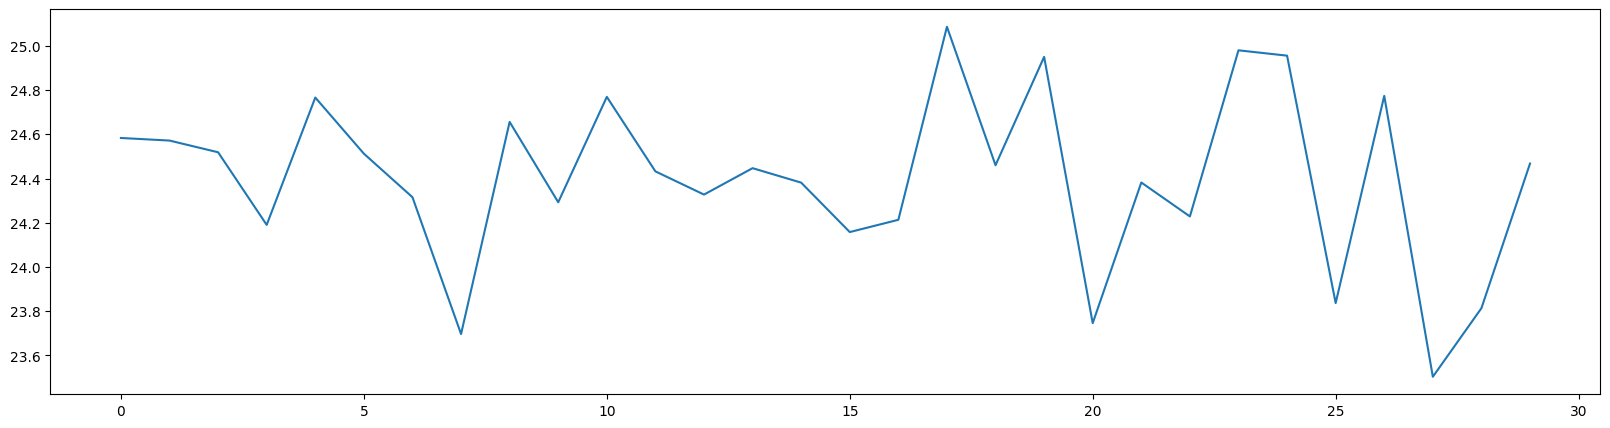

fannkuch-redux.exe.ipg.workstationone.all.min-gw.win32nt


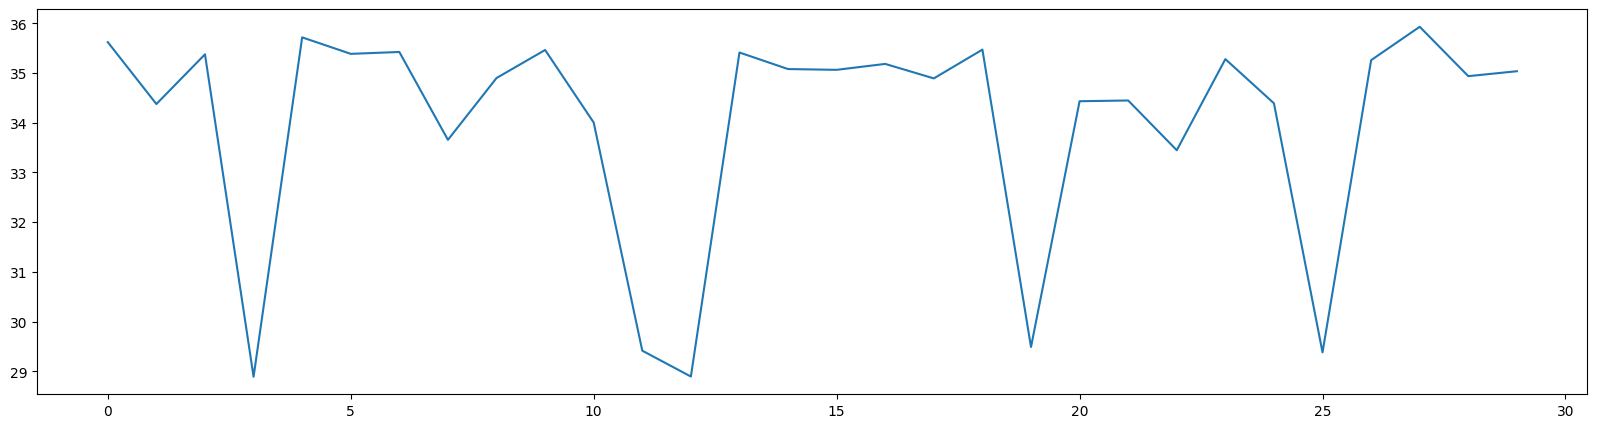

fannkuch-redux.exe.ipg.workstationone.all.msvc.win32nt


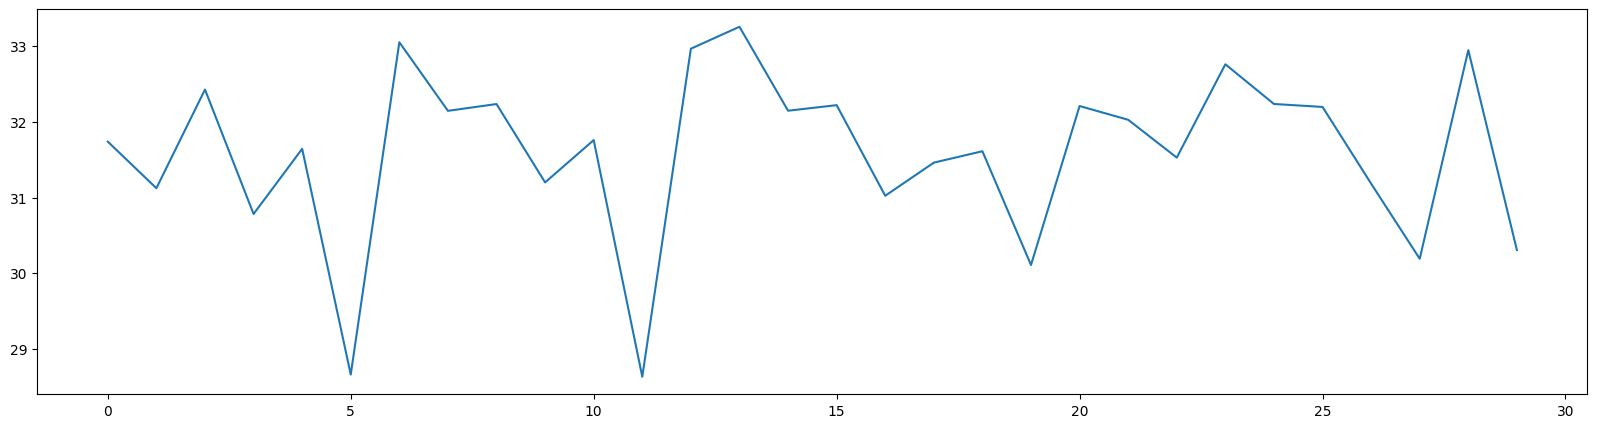

mandelbrot.exe.ipg.workstationone.all.clang.win32nt


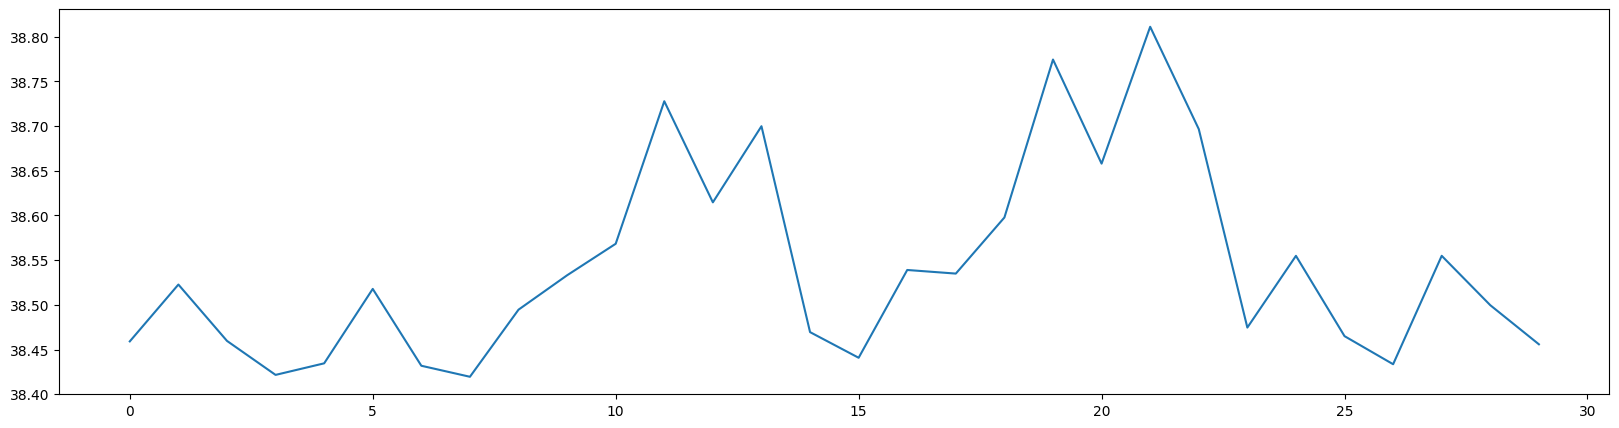

mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt


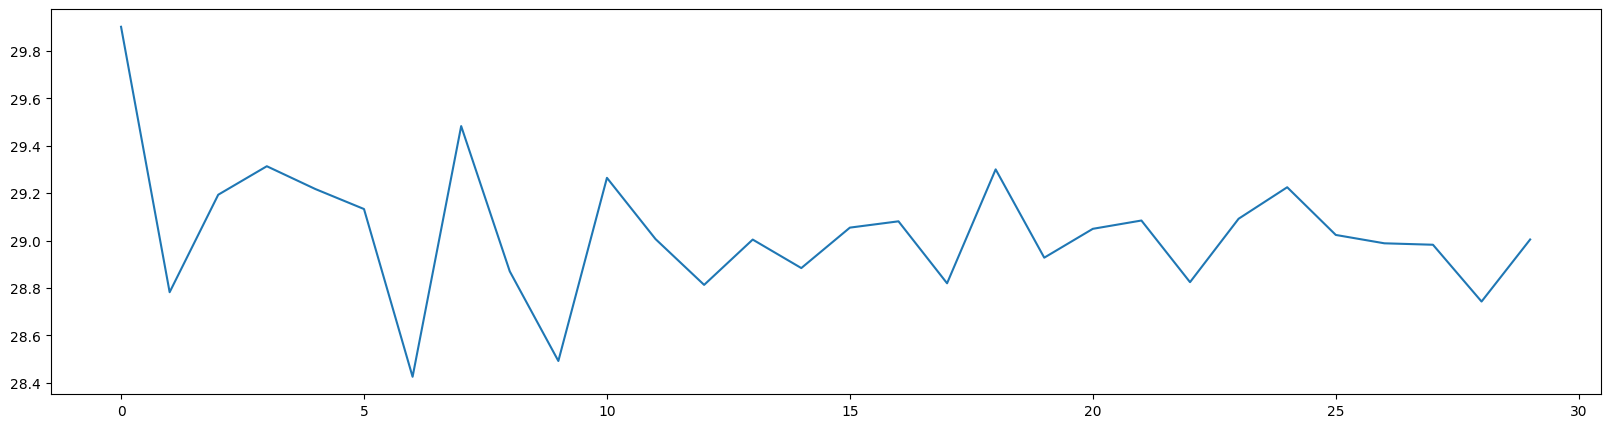

mandelbrot.exe.ipg.workstationone.all.min-gw.win32nt


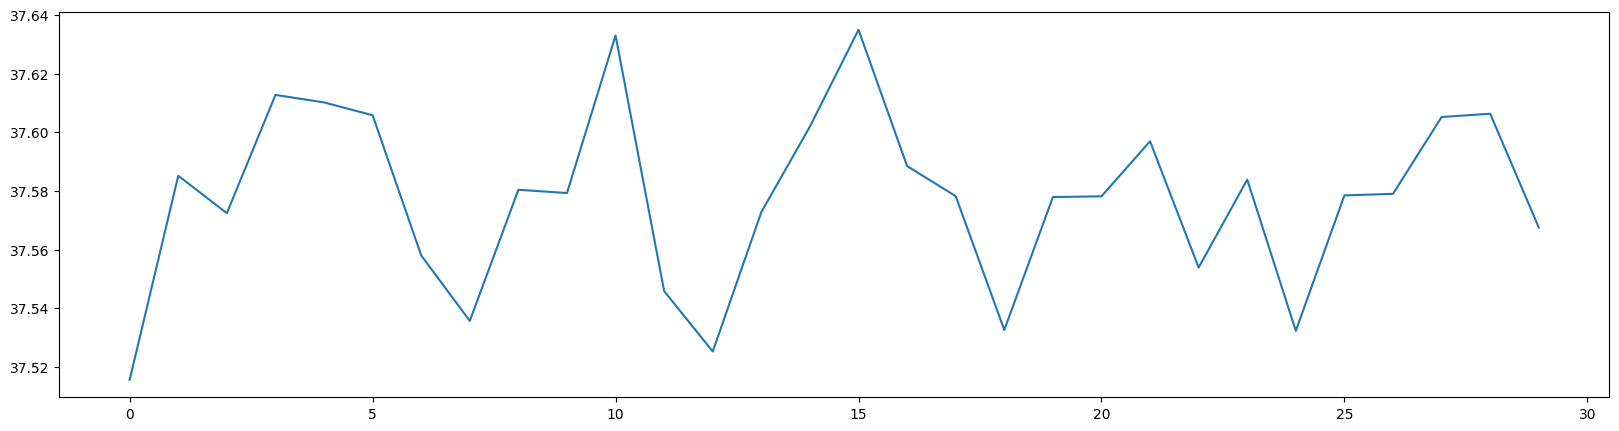

mandelbrot.exe.ipg.workstationone.all.msvc.win32nt


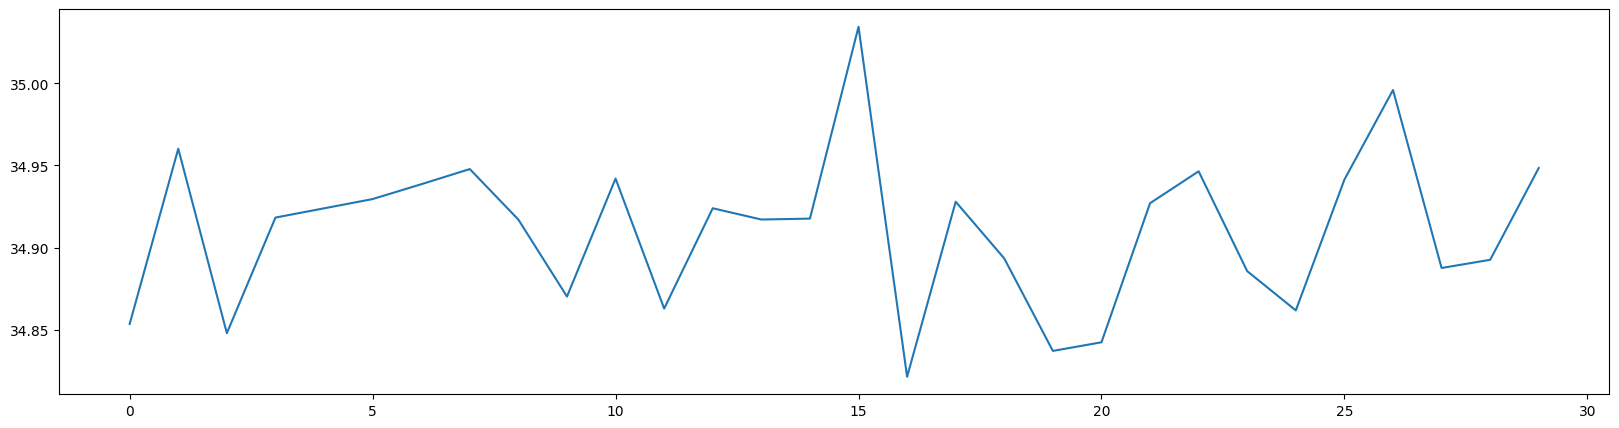

In [118]:

for column in used_df.columns:
    print(column)
    plot.rcParams["figure.figsize"] = (20,5)
    plot.plot(list(used_df[column]))
    plot.show()

